In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import ipdb

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [4]:
PATH = Path('data/pascal/')
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOCdevkit')]

In [5]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [7]:
FILE_NAME,ID,IMAGE_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]: o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]: o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [36]:
JPEGS = Path('VOCdevkit/VOC2007/JPEGImages')

In [8]:
IMG_PATH = PATH / 'VOCdevkit/VOC2007/JPEGImages'
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005504.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001055.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007773.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008820.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/004935.jpg')]

In [9]:
trn_anno = collections.defaultdict(lambda: [])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMAGE_ID]].append((bb, o[CAT_ID]))

len(trn_anno)

2501

In [10]:
im0_d = trn_j[IMAGES][0]
im0_d

{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500}

In [11]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [12]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [13]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])


In [14]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [15]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [16]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [17]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 2)

In [20]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [21]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

### Large classifier

In [23]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [24]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [25]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [27]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                   'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [29]:
f_model = resnet34
sz = 224
bs = 64

In [37]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)


In [38]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [39]:
lrf = learn.lr_find(1e-05, 100)


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:11<00:03,  2.11it/s, loss=12.1]

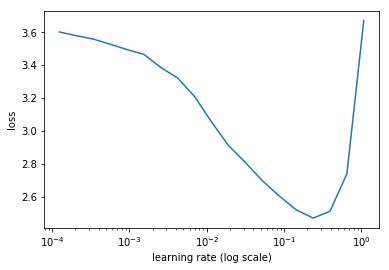

In [42]:
learn.sched.plot(5, 1)

In [43]:
lr = 2e-02

In [45]:
tqdm.monitor_interval = 0

In [46]:
learn.fit(lr, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.976871   0.697859   0.805589  



[0.69785947, 0.8055889457464218]

In [54]:
lrs = np.array([lr/1000, lr/100, lr])

In [48]:
learn.fit(lrs, n_cycle=2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.953555   0.773044   0.791767  
    1      0.682153   0.598737   0.828275                  
    2      0.66916    0.660755   0.819561                  
    3      0.548589   0.636526   0.826472                  



[0.63652647, 0.8264723569154739]

In [49]:
learn.freeze_to(-2)

In [55]:
lrf = learn.lr_find(lrs/1000)


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                    


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/belskikh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/belskikh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/belskikh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 81%|████████▏ | 26/32 [00:10<00:02,  2.52it/s, loss=2.76] 


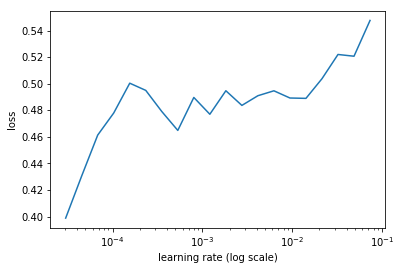

In [57]:
learn.sched.plot(1)

In [61]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.478831   0.923109   0.772386  



[0.92310864, 0.7723858207464218]

In [59]:
learn.unfreeze()

In [62]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.725731   0.537562   0.82497   
    1      0.492328   0.507756   0.828425                  



[0.50775594, 0.8284254819154739]

In [63]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


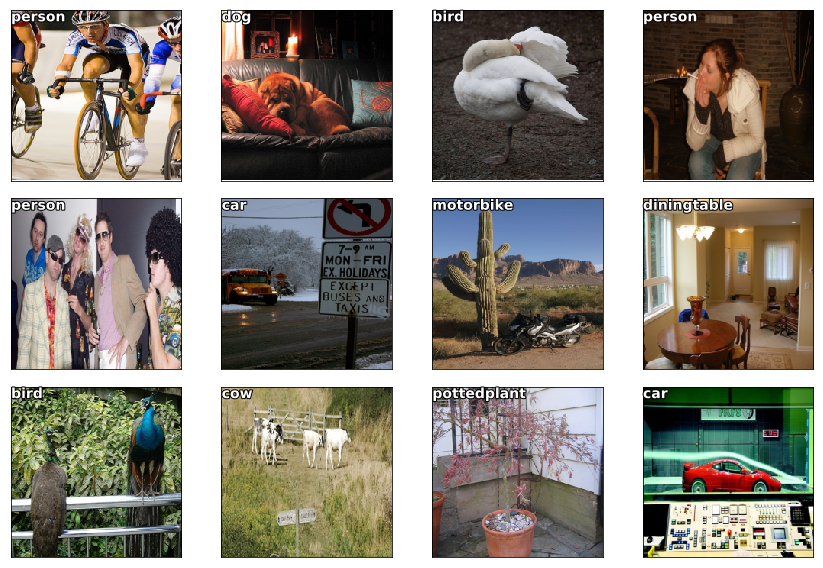

In [64]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()